# [ GLOW ] OOD Detection using FSS

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_GLOW
from core.data_loader import TRAIN_loader, TEST_loader
from core.fisher_utils_GLOW import Calculate_fisher_GLOW, Calculate_score_GLOW, AUTO_GLOW
from core.visualize import plot_hist, AUROC, plot_scores_all_layers

# Define Global Variables & Initialize

In [2]:
# FISHER_invs : Fisher inverse matrices from calculating Fisher score (w.r.t. train-dist)
FISHERs = {'cifar10': {}, 'fmnist': {}}
         
# NORMalize_FACtors : Normalizing Factor (w.r.t. train-dist)
NORM_FACs = {'cifar10': {}, 'fmnist': {}}
             
# SCOREs : (Scalars) Scores from calculating Fisher score (w.r.t. target-dist)
SCOREs = {'cifar10': {}, 'fmnist': {}}

# GLOW - CIFAR10

In [4]:
opt = config.GLOW_cifar10
model = load_pretrained_GLOW(option=opt.train_dist)
model.eval()

In [67]:
# Disassemble !!!
layers = {}
for i in range(29):
    if i in [0, 9, 19]:
    #if i in [0, 33, 67]:
        continue
    layers[f'flow{i}'] = model.flow.layers[i]

layers2 = {}
for lname, layer in layers.items():
    modules = dict(layer._modules)
    for key in modules.keys():
        layers2[f'{lname}_{key}'] = modules[key]

layers3 = {}
for lname, layer in layers2.items():
    if lname.split('_')[1] in ['actnorm', 'invconv']:
        continue
    modules = dict(layer._modules)
    conv_num = 0
    act_num = 0
    for key, value in modules.items():
        if isinstance(value, nn.ReLU):
            continue
        modules2 = dict(value._modules)
        for key2, value2 in modules2.items():
            if key2 == 'conv':
                conv_num += 1
                key3 = key2 + str(conv_num)
            elif key2 == 'actnorm':
                act_num += 1
                key3 = key2 + str(act_num)
            layers3[f'{lname}_{key3}'] = modules2[key2]
    
layers4 = {}
for key in layers2.keys():
    if key[-5:] != 'block':
        layers4[key] = layers2[key]
    else:
        for key2 in layers3.keys():
            if key2[:len(key)] == key:
                layers4[key2] = layers3[key2]
    

layers5 = {}
for lname, layer in layers4.items():
    attrs = layer._parameters.keys()
    for attr in attrs:
        x = getattr(layer, attr)
        if x == None: # ex: empty bias in conv
            continue
        else:
            layers5[f'{lname}_{attr}'] = x

params = layers5
    
        
        

In [2]:
from datetime import datetime
x = torch.rand(4000, 4000)
start = datetime.now()
y = torch.inverse(x)
print(datetime.now() - start)
torch.mm(x, y)

0:00:00.267257


tensor([[ 1.0000e+00, -4.0810e-04, -6.1631e-05,  ..., -8.6147e-04,
          5.9611e-04,  1.6138e-04],
        [ 2.0593e-05,  9.9977e-01, -1.1659e-04,  ..., -1.9318e-04,
         -1.4722e-04,  6.1363e-05],
        [-4.8429e-06,  7.1436e-05,  9.9975e-01,  ...,  2.4101e-04,
         -1.9036e-04,  1.7952e-04],
        ...,
        [-9.4548e-06, -1.8460e-04,  1.4901e-05,  ...,  9.9986e-01,
          1.5277e-04,  1.7231e-04],
        [-4.7855e-05, -1.3798e-04, -4.7050e-06,  ..., -4.2570e-04,
          1.0002e+00,  1.6390e-04],
        [ 4.9099e-06, -2.5043e-04, -7.5221e-05,  ..., -4.1127e-04,
          6.4373e-06,  1.0002e+00]])

In [78]:
a, b, _scores = AUTO_GLOW(opt, model, params, max_iter=[10, 500], method='SMW')

Files already downloaded and verified


Calculate Fisher GLOW:   0%|                                                               | 0/50000 [00:00<?, ?step/s]

12
flow1_actnorm_bias
torch.Size([1, 12, 1, 1])
torch.Size([1, 12])
12
flow1_actnorm_logs
torch.Size([1, 12, 1, 1])
torch.Size([1, 12])
144
flow1_invconv_lower
torch.Size([12, 12])
torch.Size([12, 12])
12
flow1_invconv_log_s
torch.Size([12])
torch.Size([12, 1])
144
flow1_invconv_upper
torch.Size([12, 12])
torch.Size([12, 12])
21600
flow1_block_conv1_weight
torch.Size([400, 6, 3, 3])
torch.Size([400, 54])
400
flow1_block_actnorm1_bias
torch.Size([1, 400, 1, 1])
torch.Size([1, 400])
400
flow1_block_actnorm1_logs
torch.Size([1, 400, 1, 1])
torch.Size([1, 400])
160000
flow1_block_conv2_weight
torch.Size([400, 400, 1, 1])
torch.Size([400, 400])
400
flow1_block_actnorm2_bias
torch.Size([1, 400, 1, 1])
torch.Size([1, 400])
400
flow1_block_actnorm2_logs
torch.Size([1, 400, 1, 1])
torch.Size([1, 400])
43200
flow1_block_conv3_weight
torch.Size([12, 400, 3, 3])
torch.Size([12, 3600])
12
flow1_block_conv3_bias
torch.Size([12])
torch.Size([12, 1])
12
flow2_actnorm_bias
torch.Size([1, 12, 1, 1])
tor

Calculate Fisher GLOW:   0%|                                                               | 0/50000 [00:03<?, ?step/s]


RuntimeError: CUDA out of memory. Tried to allocate 1.16 GiB (GPU 0; 24.00 GiB total capacity; 17.95 GiB already allocated; 455.91 MiB free; 19.13 GiB reserved in total by PyTorch)

In [48]:
layers = layers2

for lname in layers.keys():
    FISHERs[opt.train_dist][lname] = a[lname] 
    NORM_FACs[opt.train_dist][lname] = b[lname]
for ood in opt.ood_list:
    SCOREs[opt.train_dist][ood] = _scores[ood]

# AUROC curve
auroc = {}
for lname in layers.keys():
    _auroc = {}
    for ood in opt.ood_list:
        args = [
            SCOREs[opt.train_dist][opt.train_dist][lname],
            SCOREs[opt.train_dist][ood][lname],
        ]
        labels = [opt.train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[lname] = _auroc
    
df = pd.DataFrame(auroc).T
df = df.iloc[:, 1:]
df

In [51]:
x = list(df.index)
xx = []
for elt in x:
    if elt.split('_')[1] == 'invconv':
        xx.append(elt)

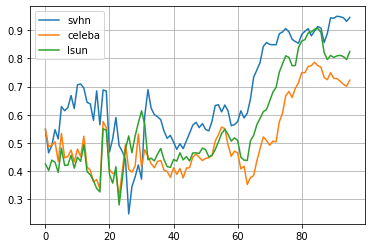

In [52]:
x = range(len(xx))
plt.plot(x, df.loc[xx, 'svhn'], label='svhn')
plt.plot(x, df.loc[xx, 'celeba'], label='celeba')
plt.plot(x, df.loc[xx, 'lsun'], label='lsun')
plt.grid()
plt.legend()


# GLOW - FMNIST

In [166]:
opt = config.GLOW_fmnist
model = load_pretrained_GLOW(option=opt.train_dist)
model.eval()

layers = {}
for i in range(29):
    if i in [0, 9, 19]:
    #if i in [0, 33, 67]:
        continue
    layers[f'flow{i}'] = model.flow.layers[i]

layers2 = {}
for lname, layer in layers.items():
    modules = dict(layer._modules)
    for key in modules.keys():
        layers2[f'{lname}_{key}'] = modules[key]

In [73]:
a, b, _scores = AUTO_GLOW(opt, model, layers2, max_iter=[1, 500], method='Vanilla')

Calculate Score GLOW:   5%|██▋                                                   | 499/10000 [00:38<12:15, 12.91step/s]


In [83]:
layers = layers2

for lname in layers.keys():
    FISHERs[train_dist][lname] = a[lname] 
    NORM_FACs[train_dist][lname] = b[lname]
for ood in opt.ood_list:
    SCOREs[train_dist][ood] = _scores[ood]

# AUROC curve
auroc = {}
for lname in layers.keys():
    _auroc = {}
    for ood in opt.ood_list:
        if ood == 'noise':
            continue
        args = [
            SCOREs[train_dist][train_dist][lname],
            SCOREs[train_dist][ood][lname],
        ]
        labels = [train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[lname] = _auroc
    
df = pd.DataFrame(auroc).T
df = df.iloc[:, 1:]
df

,mnist,kmnist,notmnist,constant
flow1_actnorm,0.999956,0.999972,0.995712,0.999944
flow1_invconv,0.992520,0.982936,0.962584,0.968748
flow1_block,1.000000,1.000000,1.000000,1.000000
flow2_actnorm,0.999996,0.999996,0.998196,1.000000
flow2_invconv,0.999112,0.998556,0.975644,0.992816
...,...,...,...,...
flow27_invconv,0.061844,0.071596,0.370832,0.276684
flow27_block,0.972340,0.950224,0.983928,0.998192
flow28_actnorm,0.311968,0.437160,0.561520,0.597460
flow28_invconv,0.005700,0.031140,0.157432,0.068472


In [87]:
x = list(df.index)
xx = []
for elt in x:
    if elt.split('_')[1] == 'block':
        xx.append(elt)

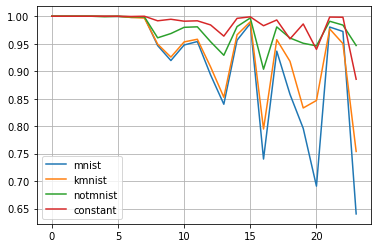

In [88]:
x = range(len(xx))
plt.plot(x, df.loc[xx, 'mnist'], label='mnist')
plt.plot(x, df.loc[xx, 'kmnist'], label='kmnist')
plt.plot(x, df.loc[xx, 'notmnist'], label='notmnist')
plt.plot(x, df.loc[xx, 'constant'], label='constant')
plt.grid()
plt.legend()

In [147]:
def postprocess(x):
    x = torch.clamp(x, -0.5, 0.5)
    x += 0.5
    x = x * 256
    return torch.clamp(x, 0, 255).byte()

In [150]:
model.flow.layers.__len__()

101

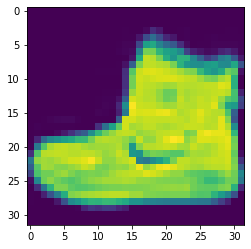

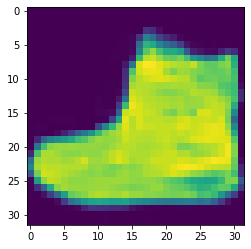

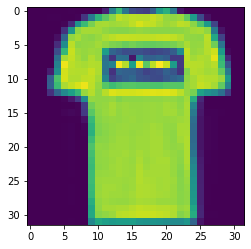

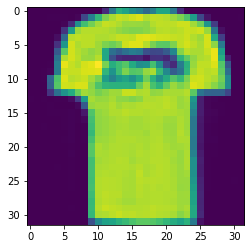

In [171]:
loader = TEST_loader('fmnist', '', shuffle=False, is_glow=True)
#loader = TRAIN_loader('fmnist', shuffle=False, is_glow=True)
for i, x in enumerate(loader):
    try:
        x, _ = x
    except:
        pass
    y = postprocess(x)
    plt.figure()
    plt.imshow(y[0].permute(1,2,0).cpu())
    x = x.to('cuda')
    z, _, _ = model(x=x)
    x = model(z=z, temperature=0.75, reverse=True)
    y = postprocess(x)
    plt.figure()
    plt.imshow(y[0].permute(1,2,0).cpu())
    if i == 1:
        break
plt.show()

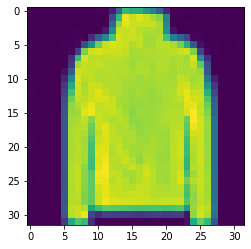

In [104]:
plt.imshow(x[0].permute(1,2,0).cpu())